In [ ]:
!pip install d2l==1.0.3


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 84.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 115.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 126.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.1/34.1 MB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.0/125.0 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.0/95.0 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 81.1 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.3
    Uninstalling requests-2.32.3:
      Succe

# Single Shot Multibox Detection

En las secciones anteriores introdujimos conceptos clave como las bounding boxes, anchor boxes, la detección de objetos a múltiples escalas y el conjunto de datos para la detección de objetos. Ahora estamos listos para utilizar este conocimiento de fondo para diseñar un modelo de detección de objetos: la Detección Multibox de Disparo Único (SSD, por sus siglas en inglés) [Liu et. al, 2015](https://arxiv.org/abs/1512.02325). Este modelo es simple, rápido y ampliamente utilizado. Aunque este es solo uno de una gran cantidad de modelos de detección de objetos, algunos de los principios de diseño y detalles de implementación en esta sección también son aplicables a otros modelos.

## Modelo

La Figura  nos brinda una visión general del diseño de la detección de SSD. Este modelo consta principalmente de una red base seguida de varios bloques de mapas de características a múltiples escalas. La red base se utiliza para extraer características de la imagen de entrada, por lo que puede utilizar una CNN profunda. Por ejemplo, el artículo original adopta una red VGG truncada antes de la capa de clasificación, aunque ResNet también se ha utilizado comúnmente. A través de nuestro diseño, podemos hacer que la red base produzca mapas de características más grandes para generar más anchor boxes para detectar objetos más pequeños. Posteriormente, cada bloque de mapas de características a múltiples escalas reduce (por ejemplo, a la mitad) la altura y el ancho de los mapas de características del bloque anterior, y permite que cada unidad de los mapas de características aumente su campo receptivo en la imagen de entrada.

En resumen, a través de su red base y varios bloques de mapas de características a múltiples escalas, la detección multibox de disparo único genera una cantidad variable de anchor boxes con diferentes tamaños y detecta objetos de diferentes tamaños prediciendo las clases y desplazamientos de estas anchor boxes (y por ende las bounding boxes); por lo tanto, este es un modelo de detección de objetos a múltiples escalas.


![As a multiscale object detection model, single-shot multibox detection mainly consists of a base network followed by several multiscale feature map blocks.](http://d2l.ai/_images/ssd.svg)

En lo siguiente, describiremos los detalles de implementación de los diferentes bloques en la Figura . Para empezar, discutimos cómo implementar la predicción de clases y bounding boxes.


### Capa de Predicción de Clases

Supongamos que el número de clases de objetos es $ q $. Luego, las anchor boxes tienen $ q+1 $ clases, donde la clase 0 es el fondo. A alguna escala, supongamos que la altura y el ancho de los mapas de características son $ h $ y $ w $, respectivamente. Cuando se generan $ a $ anchor boxes con cada posición espacial de estos mapas de características como su centro, un total de $ hwa $ anchor boxes necesitan ser clasificadas. Esto a menudo hace que la clasificación con capas densas sea inviable debido a los probables costos de parametrización pesados.

Recordemos cómo usamos los canales de las capas convolucionales para predecir clases. La detección de un solo disparo con múltiples cajas utiliza la misma técnica para reducir la complejidad del modelo.

Específicamente, la capa de predicción de clases utiliza una capa convolucional sin alterar el ancho o la altura de los mapas de características. De esta manera, puede haber una correspondencia uno a uno entre las salidas y las entradas en las mismas dimensiones espaciales (ancho y alto) de los mapas de características. Más concretamente, los canales de los mapas de características de salida en cualquier posición espacial $ (x, y) $ representan predicciones de clase para todas las anchor boxes centradas en $ (x, y) $ de los mapas de características de entrada. Para producir predicciones válidas, debe haber $ a(q+1) $ canales de salida, donde para la misma posición espacial el canal de salida con índice $ i(q+1) + j $ representa la predicción de la clase $ j $ ($ 0 \leq j \leq q $) para la anchor box $ i $ ($ 0 \leq i < a $).

A continuación, definimos una capa de predicción de clases de esta manera, especificando $ a $ y $ q $ a través de los argumentos `num_anchors` y `num_classes`, respectivamente. Esta capa utiliza una capa convolucional de $ 3\times3 $ con un relleno de 1. El ancho y la altura de la entrada y salida de esta capa convolucional permanecen sin cambios.

In [ ]:
from torch import nn
from torch.nn import functional as F

def cls_predictor(num_inputs, num_anchors, num_classes):
    return nn.Conv2d(num_inputs, num_anchors * (num_classes + 1),
                     kernel_size=3, padding=1)

### Capa de Predicción de Bounding Boxes

El diseño de la capa de predicción de bounding boxes es similar al de la capa de predicción de clases. La única diferencia radica en el número de salidas para cada anchor box: aquí necesitamos predecir cuatro desplazamientos en lugar de \( q+1 \) clases.

In [ ]:
def bbox_predictor(num_inputs, num_anchors):
    return nn.Conv2d(num_inputs, num_anchors * 4, kernel_size=3, padding=1)

### Concatenando Predicciones para Multiples Escalas

Como mencionamos, SSD utiliza mapas de características multinivel para generar anchor boxes y predecir sus clases y desplazamientos. En diferentes escalas, las formas de los mapas de características o el número de anchor boxes centradas en la misma unidad pueden variar. Por lo tanto, las formas de las salidas de predicción en diferentes escalas pueden variar.

En el siguiente ejemplo, construimos mapas de características en dos escalas diferentes, `Y1` y `Y2`, para el mismo minibatch, donde la altura y el ancho de `Y2` son la mitad de los de `Y1`. Tomemos la predicción de clase como ejemplo. Supongamos que se generan 5 y 3 anchor boxes para cada unidad en `Y1` y `Y2`, respectivamente. Supongamos además que el número de clases de objetos es 10. Para los mapas de características `Y1` y `Y2`, los números de canales en las salidas de predicción de clase son $5\times(10+1)=55$ y $3\times(10+1)=33$, respectivamente, donde la forma de salida es (tamaño del lote, número de canales, altura, ancho).

In [ ]:
import torch
def forward(x, block):
    return block(x)

Y1 = forward(torch.zeros((2, 8, 20, 20)), cls_predictor(8, 5, 10))
Y2 = forward(torch.zeros((2, 16, 10, 10)), cls_predictor(16, 3, 10))
Y1.shape, Y2.shape

(torch.Size([2, 55, 20, 20]), torch.Size([2, 33, 10, 10]))

Como podemos ver, excepto por la dimensión del tamaño del lote, las otras tres dimensiones tienen tamaños diferentes. Para concatenar estas dos salidas de predicción para una computación más eficiente, transformaremos estos tensores en un formato más consistente.

Nota que la dimensión del canal contiene las predicciones para las anchor boxes con el mismo centro. Primero movemos esta dimensión hacia la más interna. Dado que el tamaño del lote permanece igual para diferentes escalas, podemos transformar la salida de predicción en un tensor bidimensional con forma (tamaño del lote, altura $\times$ ancho $\times$ número de canales). Luego podemos concatenar tales salidas en diferentes escalas a lo largo de la dimensión 1.

In [ ]:
def flatten_pred(pred):
    return torch.flatten(pred.permute(0, 2, 3, 1), start_dim=1)

def concat_preds(preds):
    return torch.cat([flatten_pred(p) for p in preds], dim=1)

De esta manera, aunque `Y1` y `Y2` tienen tamaños diferentes en canales, alturas y anchuras, aún podemos concatenar estas dos salidas de predicción en dos escalas diferentes para el mismo minibatch.

In [ ]:
flatten_pred(Y1).shape, flatten_pred(Y2).shape, concat_preds([Y1, Y2]).shape

(torch.Size([2, 22000]), torch.Size([2, 3300]), torch.Size([2, 25300]))

### Bloque de Downsampling

Para detectar objetos en múltiples escalas, definimos el siguiente bloque de downsampling `down_sample_blk` que reduce a la mitad la altura y anchura de los mapas de características de entrada. De hecho, este bloque aplica el diseño de los bloques VGG. Más concretamente, cada bloque de downsampling consiste en dos capas convolucionales de $3\times3$ con padding de 1 seguidas por una capa de max-pooling de $2\times2$ con un stride de 2. Como sabemos, las capas convolucionales de $3\times3$ con padding de 1 no cambian la forma de los mapas de características. Sin embargo, el max-pooling de $2\times2$ subsecuente reduce la altura y anchura de los mapas de características de entrada a la mitad.

Para los mapas de características de entrada y salida de este bloque de downsampling, debido a que $1\times 2+(3-1)+(3-1)=6$, cada unidad en la salida tiene un campo receptivo de $6\times6$ en la entrada. Por lo tanto, el bloque de downsampling amplía el campo receptivo de cada unidad en sus mapas de características de salida.

In [ ]:
def down_sample_blk(in_channels, out_channels):
    blk = []
    for _ in range(2):
        blk.append(nn.Conv2d(in_channels, out_channels,
                             kernel_size=3, padding=1))
        blk.append(nn.BatchNorm2d(out_channels))
        blk.append(nn.ReLU())
        in_channels = out_channels
    blk.append(nn.MaxPool2d(2))
    return nn.Sequential(*blk)

En el siguiente ejemplo, nuestro bloque de downsampling construido cambia el número de canales de entrada y reduce a la mitad la altura y la anchura de los mapas de características de entrada.

In [ ]:
forward(torch.zeros((2, 3, 20, 20)), down_sample_blk(3, 10)).shape

torch.Size([2, 10, 10, 10])

### Bloque Base de la Red

El Bloque Base de la Red se utiliza para extraer características de las imágenes de entrada. Para simplificar, construimos un bloque de red base pequeño que consiste en tres bloques de downsampling que duplican el número de canales en cada bloque. Dada una imagen de entrada de $256 \times 256$ píxeles, este bloque base de la red produce mapas de características de $32 \times 32$ píxeles ($256/2^3=32$).

In [ ]:
def base_net():
    blk = []
    num_filters = [3, 16, 32, 64]
    for i in range(len(num_filters) - 1):
        blk.append(down_sample_blk(num_filters[i], num_filters[i+1]))
    return nn.Sequential(*blk)

forward(torch.zeros((2, 3, 256, 256)), base_net()).shape

torch.Size([2, 64, 32, 32])

### El Modelo Completo

El modelo completo de SSD consiste en cinco bloques. Los mapas de características producidos por cada bloque se utilizan tanto para (i) generar anchor boxes como (ii) para predecir las clases y desplazamientos de estos anchor boxes.

 Entre estos cinco bloques, el primero es el bloque base de la red, el segundo al cuarto son bloques de downsampling, y el último bloque utiliza un downsampling global para reducir tanto la altura como el ancho a 1. Técnicamente, el segundo al quinto bloques son todos aquellos bloques de mapas de características multinivel en la fig_ssd.

In [ ]:
def get_blk(i):
    if i == 0:
        blk = base_net()
    elif i == 1:
        blk = down_sample_blk(64, 128)
    elif i == 4:
        blk = nn.AdaptiveMaxPool2d((1,1))
    else:
        blk = down_sample_blk(128, 128)
    return blk

Ahora definimos la propagación hacia adelante para cada bloque. A diferencia de las tareas de clasificación de imágenes, las salidas aquí incluyen (i) mapas de características CNN `Y`, (ii) **anchor boxes** generadas usando `Y` en la escala actual, y (iii) clases y desplazamientos predichos (basados en `Y`) para estas **anchor boxes**.

In [ ]:
def blk_forward(X, blk, size, ratio, cls_predictor, bbox_predictor):
    Y = blk(X)
    anchors = d2l.multibox_prior(Y, sizes=size, ratios=ratio)
    cls_preds = cls_predictor(Y)
    bbox_preds = bbox_predictor(Y)
    return (Y, anchors, cls_preds, bbox_preds)

Recuerda que un bloque de mapas de características multinivel que está más cerca de la parte superior es para detectar objetos más grandes; por lo tanto, necesita generar **anchor boxes** más grandes. En la propagación hacia adelante anterior, en cada bloque de mapas de características multinivel, pasamos una lista de dos valores de escala a través del argumento `sizes` de la función `multibox_prior`. En lo siguiente, el intervalo entre 0.2 y 1.05 se divide uniformemente en cinco secciones para determinar los valores de escala más pequeños en los cinco bloques: 0.2, 0.37, 0.54, 0.71 y 0.88. Luego, sus valores de escala más grandes se dan por $\sqrt{0.2 \times 0.37} = 0.272$, $\sqrt{0.37 \times 0.54} = 0.447$, y así sucesivamente.

In [ ]:
sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79],
         [0.88, 0.961]]
ratios = [[1, 2, 0.5]] * 5
num_anchors = len(sizes[0]) + len(ratios[0]) - 1

Ahora podemos definir el modelo completo `TinySSD` de la siguiente manera.

In [ ]:
class TinySSD(nn.Module):
    def __init__(self, num_classes, **kwargs):
        super(TinySSD, self).__init__(**kwargs)
        self.num_classes = num_classes
        idx_to_in_channels = [64, 128, 128, 128, 128]
        for i in range(5):
            # Equivalente a la declaración de asignación `self.blk_i = get_blk(i)`
            setattr(self, f'blk_{i}', get_blk(i))
            setattr(self, f'cls_{i}', cls_predictor(idx_to_in_channels[i],
                                                    num_anchors, num_classes))
            setattr(self, f'bbox_{i}', bbox_predictor(idx_to_in_channels[i],
                                                      num_anchors))

    def forward(self, X):
        anchors, cls_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5
        for i in range(5):
            # Aquí `getattr(self, 'blk_%d' % i)` accede a `self.blk_i`
            X, anchors[i], cls_preds[i], bbox_preds[i] = blk_forward(
                X, getattr(self, f'blk_{i}'), sizes[i], ratios[i],
                getattr(self, f'cls_{i}'), getattr(self, f'bbox_{i}'))
        anchors = torch.cat(anchors, dim=1)
        cls_preds = concat_preds(cls_preds)
        cls_preds = cls_preds.reshape(
            cls_preds.shape[0], -1, self.num_classes + 1)
        bbox_preds = concat_preds(bbox_preds)
        return anchors, cls_preds, bbox_preds

Creamos una instancia del modelo y la usamos para realizar la propagación hacia adelante en un lote de imágenes de $256 \times 256$ `X`.

Como se mostró anteriormente en esta sección, el primer bloque produce mapas de características de $32 \times 32$. Recordemos que los bloques de downsampling segundo al cuarto dividen a la mitad la altura y el ancho, y el quinto bloque utiliza pooling global. Dado que se generan 4 anchor boxes para cada unidad a lo largo de las dimensiones espaciales de los mapas de características, en las cinco escalas se generan un total de $(32^2 + 16^2 + 8^2 + 4^2 + 1)\times 4 = 5444$ anchor boxes para cada imagen.

In [ ]:
%matplotlib inline
import torch
from d2l import torch as d2l

torch.set_printoptions(2)  # Simplify printing accuracy

In [ ]:
net = TinySSD(num_classes=1)
X = torch.zeros((32, 3, 256, 256))
anchors, cls_preds, bbox_preds = net(X)

print('output anchors:', anchors.shape)
print('output class preds:', cls_preds.shape)
print('output bbox preds:', bbox_preds.shape)

output anchors: torch.Size([1, 5444, 4])
output class preds: torch.Size([32, 5444, 2])
output bbox preds: torch.Size([32, 21776])


## Entrenamiento
Ahora explicaremos cómo entrenar SSD para la detección de objetos.



### Lectura del Conjunto de Datos e Inicialización del Modelo
Para comenzar, vamos a leer el conjunto de datos de detección de plátanos descrito en los videos anteriores.

In [ ]:
batch_size = 32
train_iter, _ = d2l.load_data_bananas(batch_size)

read 1000 training examples
read 100 validation examples


Solo hay una clase en el conjunto de datos de detección de plátanos. Después de definir el modelo, necesitamos inicializar sus parámetros y definir el algoritmo de optimización.

In [ ]:
device, net = d2l.try_gpu(), TinySSD(num_classes=1)
trainer = torch.optim.SGD(net.parameters(), lr=0.2, weight_decay=5e-4)

### Definiendo Funciones de Pérdida y Evaluación

La detección de objetos tiene dos tipos de pérdidas. La primera pérdida se refiere a las clases de las **bounding boxes**: su cálculo puede simplemente reutilizar la función de pérdida de entropía cruzada que usamos para la clasificación de imágenes. La segunda pérdida se refiere a los desplazamientos de las **bounding boxes** positivas (no de fondo): esto es un problema de regresión. Sin embargo, para este problema de regresión, aquí no utilizamos el error cuadrático medio. En cambio, usamos la pérdida de la norma $\ell_1$, el valor absoluto de la diferencia entre la predicción y el valor real. La variable de máscara `bbox_masks` filtra las **bounding boxes** negativas y las **bounding boxes** de relleno en el cálculo de la pérdida. Al final, sumamos la pérdida de clase de la **bounding box** y la pérdida de desplazamiento de la **bounding box** para obtener la función de pérdida del modelo.

In [ ]:
cls_loss = nn.CrossEntropyLoss(reduction='none')
bbox_loss = nn.L1Loss(reduction='none')

def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks):
    batch_size, num_classes = cls_preds.shape[0], cls_preds.shape[2]
    cls = cls_loss(cls_preds.reshape(-1, num_classes),
                   cls_labels.reshape(-1)).reshape(batch_size, -1).mean(dim=1)
    bbox = bbox_loss(bbox_preds * bbox_masks,
                     bbox_labels * bbox_masks).mean(dim=1)
    return cls + bbox

Podemos utilizar el accuracy para evaluar los resultados de clasificación. Debido al uso de la pérdida de norma $\ell_1$ para los desplazamientos, utilizamos el *error absoluto medio* para evaluar las **bounding boxes** predichas. Estos resultados de predicción se obtienen a partir de las **anchor boxes** generadas y los desplazamientos predichos para ellas.

In [ ]:
def cls_eval(cls_preds, cls_labels):
    # Because the class prediction results are on the final dimension,
    # `argmax` needs to specify this dimension
    return float((cls_preds.argmax(dim=-1).type(
        cls_labels.dtype) == cls_labels).sum())

def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
    return float((torch.abs((bbox_labels - bbox_preds) * bbox_masks)).sum())

### Entrenamiento del Modelo

Cuando entrenamos el modelo, necesitamos generar **anchor boxes** multiscale (`anchors`) y predecir sus clases (`cls_preds`) y desplazamientos (`bbox_preds`) en la propagación hacia adelante. Luego etiquetamos las clases (`cls_labels`) y desplazamientos (`bbox_labels`) de dichas **anchor boxes** generadas basadas en la información de las etiquetas `Y`. Finalmente, calculamos la función de pérdida utilizando los valores predichos y etiquetados de las clases y desplazamientos. Para implementaciones concisas, la evaluación del conjunto de datos de prueba se omite aquí.

class err 2.92e-03, bbox mae 2.79e-03
5178.2 examples/sec on cuda:0


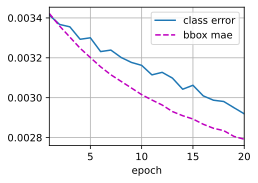

In [ ]:
num_epochs, timer = 20, d2l.Timer()
animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                        legend=['class error', 'bbox mae'])
net = net.to(device)
for epoch in range(num_epochs):
    # Sum of training accuracy, no. of examples in sum of training accuracy,
    # Sum of absolute error, no. of examples in sum of absolute error
    metric = d2l.Accumulator(4)
    net.train()
    for features, target in train_iter:
        timer.start()
        trainer.zero_grad()
        X, Y = features.to(device), target.to(device)
        # Generate multiscale anchor boxes and predict their classes and
        # offsets
        anchors, cls_preds, bbox_preds = net(X)
        # Label the classes and offsets of these anchor boxes
        bbox_labels, bbox_masks, cls_labels = d2l.multibox_target(anchors, Y)
        # Calculate the loss function using the predicted and labeled values
        # of the classes and offsets
        l = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels,
                      bbox_masks)
        l.mean().backward()
        trainer.step()
        metric.add(cls_eval(cls_preds, cls_labels), cls_labels.numel(),
                   bbox_eval(bbox_preds, bbox_labels, bbox_masks),
                   bbox_labels.numel())
    cls_err, bbox_mae = 1 - metric[0] / metric[1], metric[2] / metric[3]
    animator.add(epoch + 1, (cls_err, bbox_mae))
print(f'class err {cls_err:.2e}, bbox mae {bbox_mae:.2e}')
print(f'{len(train_iter.dataset) / timer.stop():.1f} examples/sec on '
      f'{str(device)}')

## Predicción

Durante la predicción, el objetivo es detectar todos los objetos de interés en la imagen. A continuación, leemos y redimensionamos una imagen de prueba, convirtiéndola en un tensor de cuatro dimensiones que es necesario para las capas convolucionales.

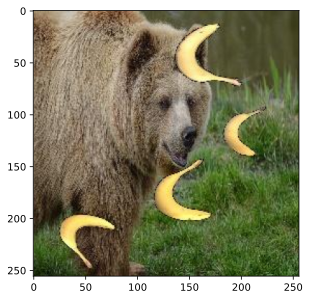

In [ ]:
import torchvision
import requests
from PIL import Image
from io import BytesIO
import numpy as np

response = requests.get("https://i.postimg.cc/BQzvk4x9/banana.jpg")
img = Image.open(BytesIO(response.content))
img.save("banana.jpg")

X = torchvision.io.read_image('banana.jpg').unsqueeze(0).float()
img = X.squeeze(0).permute(1, 2, 0).long()
d2l.plt.imshow(img)

Utilizando la función `multibox_detection` a continuación, las bounding boxes predichas se obtienen a partir de los anchor boxes y sus desplazamientos predichos. Luego se utiliza la supresión de no máximos para eliminar bounding boxes predichas similares.

In [ ]:
def predict(X):
    net.eval()
    anchors, cls_preds, bbox_preds = net(X.to(device))
    cls_probs = F.softmax(cls_preds, dim=2).permute(0, 2, 1)
    output = d2l.multibox_detection(cls_probs, bbox_preds, anchors)
    idx = [i for i, row in enumerate(output[0]) if row[0] != -1]
    return output[0, idx]

output = predict(X)

In [ ]:
output.shape

torch.Size([34, 6])

Finalmente, mostramos todas las bounding boxes predichas con una confianza de 0.9 o superior como salida.

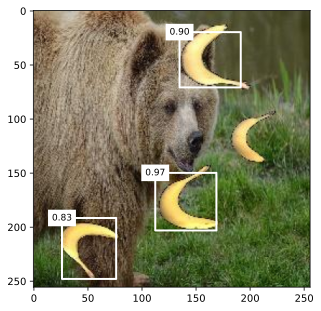

In [ ]:
def display(img, output, threshold):
    d2l.set_figsize((5, 5))
    fig = d2l.plt.imshow(img)
    for row in output:
        score = float(row[1])
        if score < threshold:
            continue
        h, w = img.shape[:2]
        bbox = [row[2:6] * torch.tensor((w, h, w, h), device=row.device)]
        d2l.show_bboxes(fig.axes, bbox, '%.2f' % score, 'w')

display(img, output.cpu(), threshold=0.8)